# Pruning Pathfinder

In [7]:
import sys
import json
default = {'scenario': 'base', 'training_folder': '../..'} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))

sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from quetzal.model import stepmodel
from quetzal.engine.pathfinder_utils import efficient_od_sets

import pandas as pd

## Read Model

In [8]:
sm = stepmodel.read_zippedpickles(argv['training_folder'] + '/model/{scen}/walk_model'.format(scen=argv['scenario']))

distribution = stepmodel.read_zippedpickles((argv['training_folder'] + '/model/{scen}/distribution'.format(scen=argv['scenario'])))
sm.volumes = distribution.volumes

epsg: 100%|██████████| 3/3 [00:00<00:00, 1388.08it/s]


## BEST PATHS

In [9]:
tc = sm.copy()
tc.step_pt_pathfinder(
    broken_routes = False,
    broken_modes = False,
    keep_pathfinder = True,
    mode_column = 'route_type',
    route_column = 'route_short_name',
    speedup = True,
    cutoff = 6000, # Max path length
    walk_on_road = False, # Using footpaths
    path_analysis = True,
    engine ='b', # b is faster
)

ppf = tc.publicpathfinder
tc.pt_los.head(5)

path_analysis: 100%|██████████| 12100/12100 [00:00<00:00, 58211.46it/s]


,origin,destination,gtime,path,pathfinder_session,reversed,boardings,alightings,node_path,link_path,footpaths,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path
0,zone_0,zone_0,0.000000,"(zone_0,)",best_path,False,[],[],[],[],[],[],[],[],[],True,0,0.0,0.0
1,zone_0,zone_1,896.021282,"(zone_0, 244, zone_1)",best_path,False,[],[],[244],[],[],"[(zone_0, 244), (244, zone_1)]",[],[],[],True,0,0.0,0.0
2,zone_0,zone_10,1413.673089,"(zone_0, 244, link_3654, link_3655, link_3656,...",best_path,False,"[244, 163]","[163, 253]","[244, 163, 253]","[link_3654, link_3655, link_3656, link_4524]",[],"[(zone_0, 244), (253, zone_10)]",[163],"[link_3654, link_4524]","[link_3656, link_4524]",False,1,360.0,NaN
3,zone_0,zone_100,2041.824458,"(zone_0, 244, link_4303, link_4304, 170, link_...",best_path,False,"[244, 170, 64, 132]","[170, 64, 132, 217]","[244, 170, 64, 132, 217]","[link_4303, link_4304, link_4966, link_4967, l...",[],"[(zone_0, 244), (217, zone_100)]","[170, 64, 132]","[link_4303, link_4966, link_4406, link_4727]","[link_4304, link_4970, link_4407, link_4729]",False,3,780.0,NaN
4,zone_0,zone_101,1604.955356,"(zone_0, 244, link_4303, link_4304, 170, link_...",best_path,False,"[244, 170, 64, 98]","[170, 64, 98, 174]","[244, 170, 64, 98, 174]","[link_4303, link_4304, link_4966, link_4967, l...",[],"[(zone_0, 244), (174, zone_101)]","[170, 64, 98]","[link_4303, link_4966, link_4406, link_5126]","[link_4304, link_4970, link_4406, link_5126]",False,3,600.0,NaN


# Route and Mode Breaker (pruning)
### Routes Breaker: 
We remove, each time, one line of type Tram, Rail or Subway

In [10]:
ppf.combinations = dict()
rail = tc.links.loc[tc.links['route_type'].isin(['tram', 'subway', 'rail'])] 
broken_routes = rail["route_short_name"].unique()
ppf.combinations['route_id'] = [{route} for route in broken_routes]
print('Broken Routes:', broken_routes)

Broken Routes: ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '3B' '7B'
 'T3B' 'T2' 'T3A' 'C' 'D' 'E' 'L' 'A' 'B']


### Mode Breaker
We remove one mode at the time then we remove all modes to generate "all walk" path

In [11]:
mode_combinations = []
mode_combinations.append(set(tc.links['route_type'].unique()))
for mode in tc.links['route_type'].unique():
    mode_combinations.append({mode})
print('Broken Modes Combinaison:', mode_combinations)

Broken Modes Combinaison: [{'tram', 'subway', 'bus', 'rail'}, {'bus'}, {'subway'}, {'tram'}, {'rail'}]


### OD Sets
For a faster iterations, we limit pathfinder to OD that show be affected by the removed line

In [12]:
ppf.combinations = dict()
ppf.links['route_id'] = ppf.links['route_short_name']
ppf.combinations['route_id'] = [{route} for route in broken_routes]
ppf.combinations['route_type'] = mode_combinations
ppf.build_route_id_sets(first_and_last_only=True)
ppf.build_route_type_sets(first_and_last_only=False)
ppf.build_od_sets()

ppf.splitted_od_sets['route_id'] = {
    c : efficient_od_sets(od_set, factor=0.6, verbose=False) 
    for c, od_set in ppf.od_sets['route_id'].items()
}

### Route Breaker Pathfinder

In [13]:
ppf.find_broken_combination_paths(column='route_id', cutoff = 6000, build_shortcuts=False, prune=False)
ppf.broken_route_paths = ppf.broken_combination_paths
ppf.broken_route_paths['pathfinder_session'] = 'route_breaker' 
ppf.broken_route_paths['broken_route'] = ppf.broken_route_paths['broken_route_id'].apply(lambda s: list(s)[0] )

route_id {'5'}: 100%|██████████| 25/25 [00:03<00:00,  7.26it/s]  


### Mode Breaker Pathfinder

In [14]:
ppf.find_broken_combination_paths(column='route_type', cutoff = 6000, build_shortcuts=False, prune=False)
ppf.broken_mode_paths = ppf.broken_combination_paths
ppf.broken_mode_paths['pathfinder_session'] = 'mode_breaker'
ppf.broken_mode_paths['broken_modes'] = ppf.broken_mode_paths['broken_route_type'].apply(set)

route_type {'tram', 'subway', 'bus', 'rail'}: 100%|██████████| 5/5 [00:01<00:00,  4.46it/s]


### Concatenate paths

In [15]:
pt_los = pd.concat([
    ppf.best_paths,
    ppf.broken_mode_paths, 
    ppf.broken_route_paths, 
    ]
)
pt_los['path'] = [tuple(p) for p in pt_los['path']]
pt_los = pt_los.drop_duplicates(subset=['path'])
pt_los['time'] = pt_los['gtime']
print('Total path: ', len(pt_los))
tc.pt_los = pt_los
pt_los.set_index(['origin', 'destination'])['pathfinder_session'].value_counts()

Total path:  50898


mode_breaker     26132
route_breaker    12666
best_path        12100
Name: pathfinder_session, dtype: int64

# Export

In [17]:
tc.to_zippedpickles((argv['training_folder'] + '/model/{scen}/pruning_pt_pathfinder'.format(scen=argv['scenario'])))

pt_los: 100%|██████████| 32/32 [00:01<00:00, 16.90it/s]                 


# Plot

In [18]:
if not manual:
    end_of_notebook
    
import matplotlib.pyplot as plt

100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


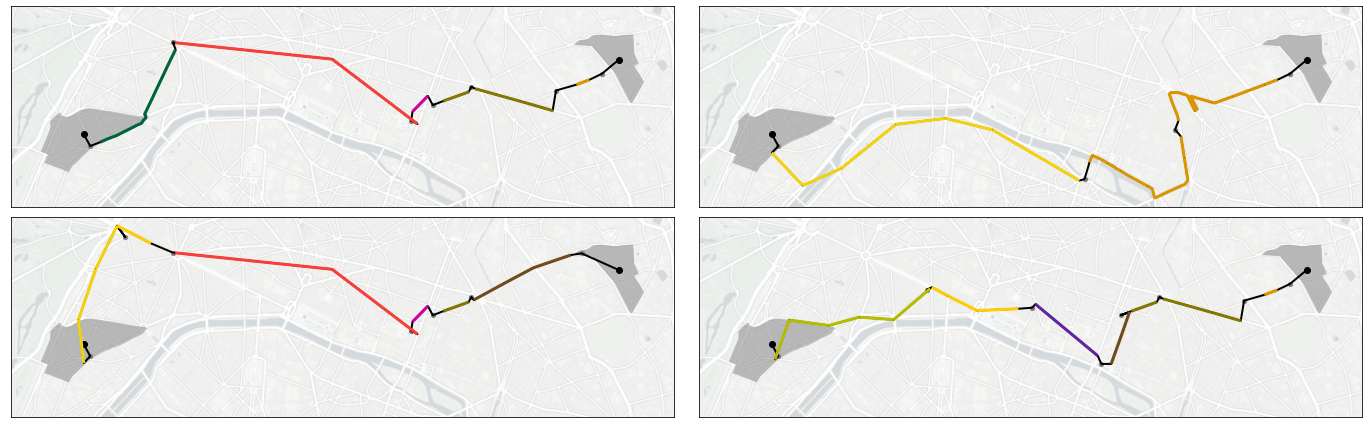

In [19]:
tc.links['color'] = '#' + tc.links['route_color']
origin, destination='zone_74',  'zone_105'
rows = 3
fig, axes = tc.plot_separated_paths(
    origin, destination, rows=rows, figsize=[20, 20],
    title=None, constrained_layout=True, zoom=13, resize=True,
    basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png', 
)

# END